In [93]:
import warnings # Omitir mensajes de advertencia
warnings.filterwarnings("ignore")

In [94]:
# Trabajamos en colab:
from google.colab import drive
drive.mount('/content/drive/')

import os

path = '/content/drive/MyDrive/Colab Notebooks/LessonGH/'

os.chdir(path)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import calendar
from scipy.stats import gamma, norm
import matplotlib.ticker as mticker
import matplotlib.dates as mdates

### Standardized Precipitation Index (SPI)
* [Fuente](https://www.sciencedirect.com/topics/agricultural-and-biological-sciences/standardized-precipitation-index#:~:text=The%20SPI%20describes%20the%20amount,and%2012-month%20periods)

---









In [96]:
def calculate_spi(df, spi_type=1, start_date='1981-01', end_date='2010-12'):
    df_copy = df.copy()

    # Convertir las fechas a formato datetime
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # Crear la columna de tiempo e indexarla
    df_copy['time'] = pd.date_range(start_date, end_date, freq='MS')
    df_copy.set_index('time', inplace=True)

    # Seleccionar los datos de precipitación
    data_idx = df_copy[['pp']]

    # Calcular la media móvil según el tipo de SPI
    if (spi_type == 1):
        data_idx[f'pp_spi{spi_type}'] = data_idx['pp']
    else:
        data_idx[f'pp_spi{spi_type}'] = data_idx['pp'].rolling(window=spi_type).mean()

    data_idx_spi = data_idx[[f'pp_spi{spi_type}']]

    # Crear un diccionario para almacenar los DataFrames de cada mes
    meses = {calendar.month_abbr[mes_num].lower(): data_idx_spi[data_idx_spi.index.month == mes_num].reset_index(drop=True)
             for mes_num in range(1, 13)}

    for mes_num, mes in meses.items():
        mes.rename(columns={f'pp_spi{spi_type}': f'pp{mes_num}_spi{spi_type}'}, inplace=True)

    data_piv = pd.concat(meses.values(), axis=1)
    data_piv = data_piv.replace(0, np.nan)

    # Calcular el logaritmo natural de las columnas
    for columna in data_piv.columns:
        data_piv[f'Ln_{columna}'] = np.log(data_piv[columna])

    prom_columns = data_piv.filter(regex=f'^pp').mean().to_numpy()
    Sum_Ln_Columns = data_piv.filter(regex='^Ln_').sum().to_numpy()
    n = data_piv.filter(regex=f'^pp').count().to_numpy()

    A = np.log(prom_columns) - Sum_Ln_Columns / n
    a = (1 / (4 * A)) * (1 + np.sqrt(1 + (4 * A) / 3))
    b = prom_columns / a
    t = len(data_piv)
    q = (t-n)/t if spi_type==1 else np.concatenate(((t-1-n[:spi_type-1])/(t-1),(t-n[spi_type-1:])/t))

    gamma_cdf = gamma.cdf(data_piv.filter(regex=f'^pp'), a, scale=b)
    gamma_cdf = np.nan_to_num(gamma_cdf, nan=0)

    gamma_2 = q + (1 - q) * gamma_cdf
    gamma_2_flatt = gamma_2.flatten()

    if spi_type > 1:
        gamma_2_flatt[:spi_type - 1] = np.nan

    SPI = norm.ppf(gamma_2_flatt, loc=0, scale=1)
    SPI_df = pd.DataFrame({f'SPI_{spi_type}': SPI})

    # Categorizar los valores de SPI
    def categorize_spi(value):
        if value <= -2:
            return 'extremely drought'
        elif value <= -1.5:
            return 'severely drought'
        elif value <= -1:
            return 'moderately drought'
        elif value <= 1:
            return 'near normal'
        elif value <= 1.5:
            return 'moderately wet'
        elif value <= 2:
            return 'very wet'
        elif value > 2:
            return 'extremely wet'
        else:
            return np.nan

    df_pp_spi = df['pp'].rolling(window=spi_type).mean().rename(f'pp_SPI_{spi_type}')
    SPI_df[f'Category'] = SPI_df[f'SPI_{spi_type}'].apply(categorize_spi)
    df_result = pd.concat([df, df_pp_spi, SPI_df], axis=1)
    return df_result


In [99]:
df = pd.read_excel(path + 'DataGH/Chuquibambilla_Puno.xlsx')
df_spi = calculate_spi(df, spi_type=1, start_date='1956-01', end_date='2013-12')

### Gráfico

In [100]:
df_spi.set_index('time', inplace = True)
df_spi
# df_spi.to_excel('spi6_chuquibambilla.xlsx')

,pp,pp_SPI_1,SPI_1,Category
time,,,,
1956-01-01,142.8,142.8,-0.118232,near normal
1956-02-01,75.1,75.1,-1.183995,moderately drought
1956-03-01,42.6,42.6,-2.442516,extremely drought
1956-04-01,8.1,8.1,-2.130174,extremely drought
1956-05-01,3.6,3.6,-0.236710,near normal
...,...,...,...,...
2013-08-01,7.4,7.4,0.576161,near normal
2013-09-01,5.3,5.3,-0.817937,near normal
2013-10-01,57.3,57.3,0.522719,near normal


In [84]:
custom_order = ['extremely wet', 'very wet', 'moderately wet', 'near normal',
                'moderately drought', 'severely drought', 'extremely drought']
# Calcular el porcentaje que representa cada categoría de SPI y ordenarlo
category_percentage_df = df_spi['Category'].value_counts(normalize=True) * 100
category_percentage_df = category_percentage_df.reindex(custom_order).reset_index()
category_percentage_df.columns = ['Category', 'Percentage']
category_percentage_df

,Category,Percentage
0,extremely wet,1.302460
1,very wet,5.209841
2,moderately wet,9.117221
3,near normal,68.162084
4,moderately drought,8.683068
5,severely drought,4.630970
6,extremely drought,2.894356


In [80]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_spi(df, spi_type=1):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    # Gráfico de líneas
    ax1.fill_between(df.index, df[f'SPI_{spi_type}'], where=df[f'SPI_{spi_type}'] > 0, color='red')
    ax1.fill_between(df.index, df[f'SPI_{spi_type}'], where=df[f'SPI_{spi_type}'] < 0, color='blue')
    ax1.xaxis.set_major_locator(mdates.YearLocator(5))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax1.set_ylabel(f'SPI_{spi_type}', fontsize=12)
    ax1.grid(linewidth=1, color='dimgrey', linestyle='--', alpha=0.75)
    plt.sca(ax1)
    plt.xticks(rotation=45)  # Rotar las etiquetas del eje x

    # Gráfico de barras
    colors = ['blue' if 'wet' in cat else 'red' if 'drought' in cat else 'lightblue' for cat in category_percentage_df['Category']]
    ax2.barh(category_percentage_df['Category'], category_percentage_df['Percentage'], color=colors)

    # Agregar los valores del porcentaje en las barras
    for i, v in enumerate(category_percentage_df['Percentage']):
        ax2.text(v, i, f'{v:.2f}%', va='center', color='black', fontsize=8)
    ax2.set_xlabel('Porcentaje')
    ax2.grid(linewidth=1, color='dimgrey', linestyle='--', alpha=0.75)
    plt.tight_layout()
    plt.show()

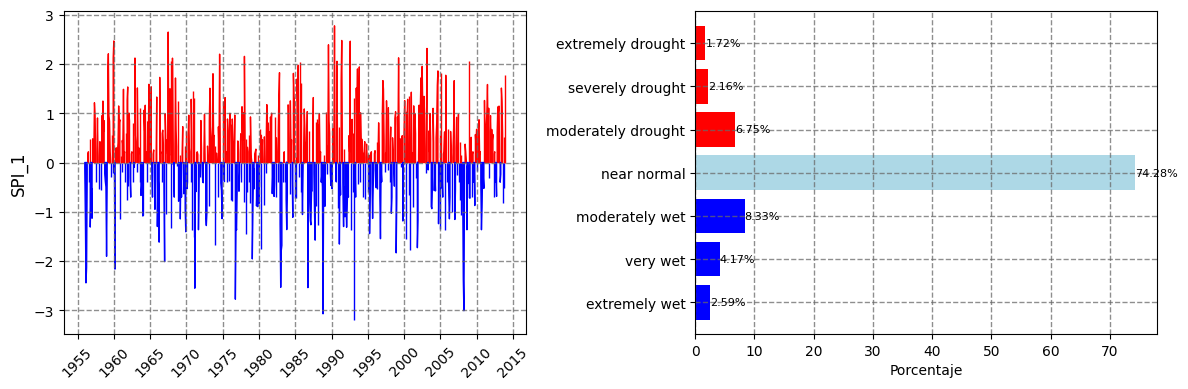

In [69]:
plot_spi(df_spi, spi_type=int(df_spi.filter(regex='^SPI_').columns[0][4:]))

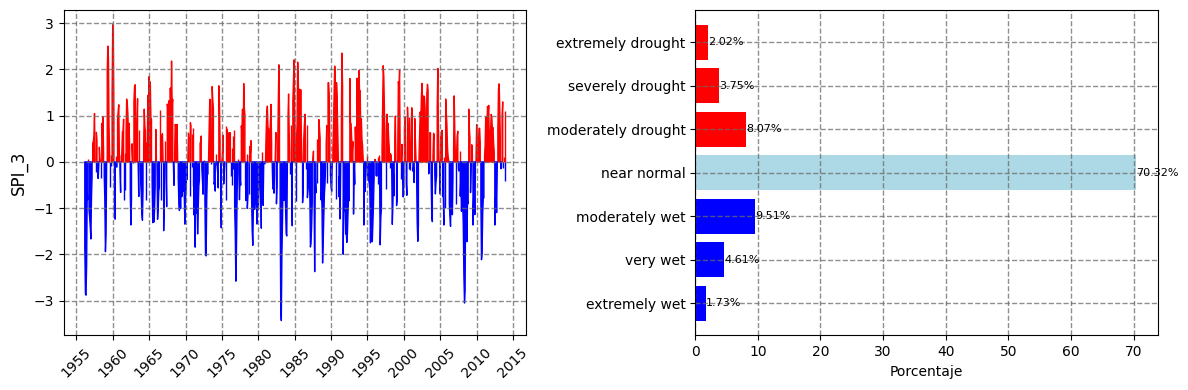

In [81]:
plot_spi(df_spi, spi_type=int(df_spi.filter(regex='^SPI_').columns[0][4:]))

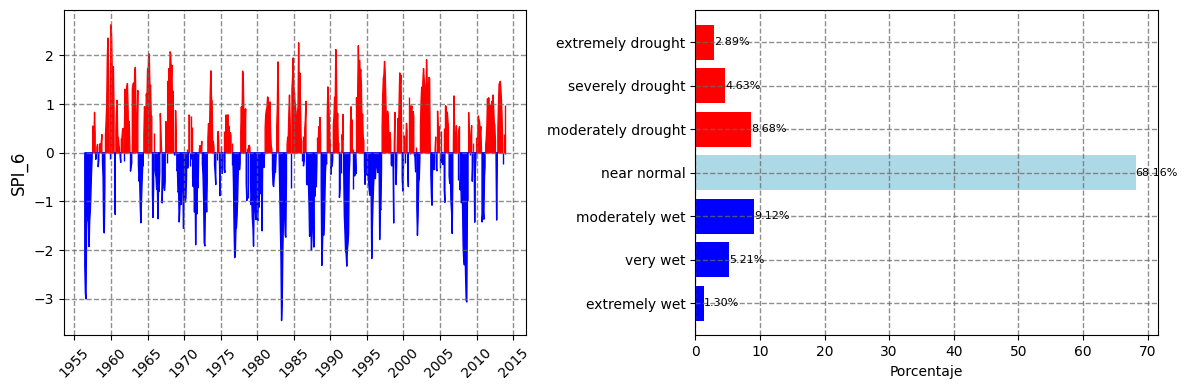

In [85]:
plot_spi(df_spi, spi_type=int(df_spi.filter(regex='^SPI_').columns[0][4:]))